In [1]:
from __future__ import print_function

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Use for 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
# Use 16bit mmixed precision
#tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [3]:
# Last run and intentions
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
Uniqueness_of_model = 'NewFilteredFilterd_PulsetrainTest dataset didnt work well: changing to FindPeaks_pulsed_train'
print(f'{time_stamp}')


07_February_22_07_23


In [4]:
import wandb
from wandb.keras import WandbCallback


wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+"_"+time_stamp)
 


wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
# base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
# base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_131121_2213' # Model was trained originally with this
#base_path = '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'
base_path = '../all_block_data\PulsedTrainTest\Dec_Train_block_len_21_220122_1449_FindPeaks' #

# Confirm path is right...
print(f'{os.path.isdir(base_path)}')

True


In [6]:

raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
all_data = raw_data1['echo_cnn_input']
all_target = raw_data1['echo_cnn_target']

coords = raw_data1['coords']
echo_idx = raw_data1['orig_echo_idx']

# Set all nan in the data to zero
nan_idx = np.isnan(all_data).any(axis =-1)
all_target[nan_idx] = 0
all_data[ np.isnan(all_data) ]= 0



In [7]:
# Truncate data because data after truncate point is notgood for training
truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 600

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')


In [8]:
row_length = 21 # CHANGE HERE <==
col_length = 15

# Check that the dimension of data is correct
if all_data.shape[1] == row_length*col_length:
    print('Dimensions match')
else:
    print(f' Row block length:{row_length} and col length:{col_length} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [9]:
max_class = row_length 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    random.Random(13).shuffle(coords)
    # random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1,1), order = 'F' )
x_train = x_train[:,:,mid_pt-2:mid_pt+3,:]

x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1,1), order = 'F'  )
x_test = x_test[:,:,mid_pt-2:mid_pt+3,:]

x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1,1), order = 'F'  )
x_val = x_val[:,:,mid_pt-2:mid_pt+3,:]

y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_1hot  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(993792, 21, 5, 1)  X_test:(186336, 21, 5, 1)
Shape of y_train:(993792,)  y_test:(186336,)


In [10]:
print(num_classes)
print(len(np.unique(y_train)))

22
21


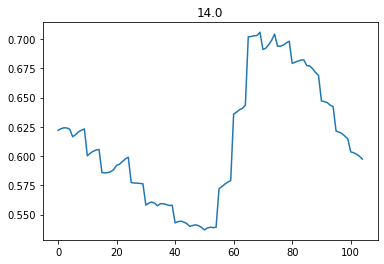

In [11]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten()) 
_ = plt.title(y_train[rand_idx])

In [12]:
# Populate the param log
log ={}
log['Notebook_name'] = ipynbname.name()
log['Uniqueness_of_each_run'] = 'First training of Pulsed Filteredfiltered using convolution model'
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too
log['extras'] = ''


from model_hyper_param_log import create_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([16, '07_February_22_0724', 'NewConv1_model-Copy1', 'First training of Pulsed Filteredfiltered using convolution model', '../all_block_data\\PulsedTrainTest\\Dec_Train_block_len_21_220122_1449_FindPeaks', (993792, 21, 5, 1), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'AQ-LHJBMA1', ''])
Fields to be updated include: ['Activation_function', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_

In [13]:
# Legacy script 

if 0:
    
    # Convolution
    x = Conv2D(32,3,padding="same",activation='relu')(aug_inputs)
    x = Conv2D(64,3,padding="same",activation='relu')(x)

    # Upsample
    up1 = UpSampling2D(size=(3,3))(x)
    up1 = Conv2D(32,3,padding="same",activation='relu')(up1)
    up1 = Conv2D(64,3,padding="same",activation='relu')(up1)

    # Downsample
    down1 = MaxPooling2D(3,padding="same")(x)
    down1 = Conv2D(32,3,padding="same",activation='relu')(down1)
    down1 = Conv2D(64,3,padding="same",activation='relu')(down1)

    # Merge resolutions and flatten

    #(a) Downsample the upsampled image
    up1_down = MaxPool2D(pool_size=(3,3))(up1)
    down1_up = UpSampling2D(size=(3,3))(down1)

    #(b) # Intermediate input - Add, convolve, flatten
    intmd_inputs = add([x,up1_down,down1_up])
    intmd_inputs = layers.LayerNormalization(epsilon=1e-5)(intmd_inputs)

    intmd_inputs = Conv2D(32,3,padding="valid",activation='relu')(intmd_inputs)
    intmd_inputs = Conv2D(1,3,padding="valid",activation='relu')(intmd_inputs)
    intmd_inputs = Flatten()(intmd_inputs)

In [14]:
# Define Sequential model with 3 layers
num_epochs = 100
batch_size = 512
nodes = 512
learning_rate = 1e-3

wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs,
  "batch_size": batch_size,
  "nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
   "shuffle": shuffle
}
wandb.config.update(log)
log['extras'] = wandb.config

input_shape = x_train.shape[1:] #(21,5,1)

def ResNetBlock(x):       

    filter_sz = (21,3)
    num_filters = 512
    x =   layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    
    conv4 = layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(conv3)
    conv4 = layers.BatchNormalization()(conv3)
    conv4 = layers.ReLU()(conv3)
    
    
    conv5 = layers.Conv2D(filters=num_filters, kernel_size=filter_sz, padding="same")(conv4)
    conv5 = layers.BatchNormalization()(conv4)
    conv5 = layers.ReLU()(conv4)
    
    conv5 = layers.add([x,conv5])
    x = layers.ReLU()(conv5) # Overwrite x
    
    return x

def ResNetBlock2(x):       

    filter_sz = (5,3) #(21,3)
    num_filters = 512
    # Convolution
    x = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(x)
    x = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(x)

    # Upsample
    up1 = UpSampling2D(size=(3,3))(x)
    up1 = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(up1)
    up1 = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(up1)

    # Downsample
    down1 = MaxPooling2D(3,padding="same")(x)
    down1 = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(down1)
    down1 = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(down1)

    # Merge resolutions and flatten

    #(a) Downsample the upsampled image
    up1_down = MaxPool2D(pool_size=(3,3))(up1)
    down1_up = UpSampling2D(size=(3,3))(down1)

    #(b) # Intermediate input - Add, convolve, flatten
    intmd_inputs = add([x,up1_down,down1_up])
    intmd_inputs = layers.LayerNormalization(epsilon=1e-5)(intmd_inputs)

    intmd_inputs = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(intmd_inputs)
    #intmd_inputs = Conv2D(1,3,padding="valid",activation='relu')(intmd_inputs)
    # intmd_inputs = MaxPool2D(pool_size=(3,3))(intmd_inputs)
    # intmd_inputs = Flatten()(intmd_inputs)   
    return x


def ConvBlock(x,filter_sz = (5,3), num_filters = 64):
    
    x = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(x)
    x = Conv2D(filters=num_filters,kernel_size=filter_sz,padding="same",activation='relu')(x)
    x = MaxPooling2D(3,padding="same")(x)
    
def double_conv_layer(x, filter_size = 3, size = 64, dropout = 0, batch_norm=False):
    '''
    construction of a double convolutional layer using
    SAME padding
    RELU nonlinear activation function
    :param x: input
    :param filter_size: size of convolutional filter
    :param size: number of filters
    :param dropout: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: output of a double convolutional layer
    '''
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv) # Sreeni removed this
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    
    # Sreeni did not add this part ( he returned conv from here (Error - this was another fxn))
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path

# Augmentation Layer
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2),
                                     ])

def make_model(input_shape):
    input_layer = layers.Input(input_shape)
    
    #x =   input_layer #layers.Conv2D(filters=64, kernel_size=3, padding="same")(input_layer)
    
    #x = data_augmentation(input_layer): This is to prevent overfitting
    
    x =   input_layer
    
    for _ in range(10):
        x = double_conv_layer(x, size = 512)        
    
    x = layers.MaxPooling2D()(x) # DownSample
    
    for _ in range(10):
        x = double_conv_layer(x, size = 512)
    
    gap = layers.Flatten()(x)
    gap = layers.Dense(512, activation="relu")(gap)
    gap = layers.Dropout(0.1)(gap)
    output_layer = layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape = input_shape) #x_train.shape[1:]


callbacks = [
    ModelCheckpoint(f"{ipynbname.name()}//Checkpoint_best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=5, min_lr=0.0001, verbose = 1),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99, nesterov=True, name="SGD")
opt4 = tfa.optimizers.AdamW(weight_decay = 0.0001, learning_rate=learning_rate) #weight_decay = 0.001, learning_rate=learning_rate,

radam = tfa.optimizers.RectifiedAdam(lr = learning_rate)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

# top_K = 3
# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M');
print(f'Training start time{start_time}')

model.compile( optimizer =radam, loss="categorical_crossentropy", metrics=["accuracy"],) #sparse_, sparse_categorical_accuracy, accuracy


history = model.fit(x_train, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test_1hot),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]
end_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {end_time}')


C:\Users\i368o351\.conda\envs\ibk_tf_new\lib\site-packages\tensorflow_addons\optimizers\rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training start time07_February_22_07_24
Epoch 1/100
 602/1941 [========>.....................] - ETA: 15:50:24 - loss: 2.5209 - accuracy: 0.2121

KeyboardInterrupt: 

In [ ]:
y_val_1hot = tf.keras.utils.to_categorical(y_val, num_classes)
_, accuracy = model.evaluate(x_val, y_val_1hot)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


model.save(f'{base_path}//NewResNet_3Conv//{time_stamp}_Acc_{accuracy}_{row_length}x{col_length}.h5')

In [ ]:
# Check some predictions

import random
check_start = random.randint(0,len(x_val))

print(f'Check start {check_start}')
[(int(y_val[idx]), np.argmax(model.predict(np.expand_dims(x_val[idx],axis=0))) ) for idx in range(check_start,check_start+20) ]



In [ ]:
from keras import backend as K

K.set_value(model.optimizer.learning_rate, 0.001)

In [ ]:
# Train further

history = model.fit(x_train, y_train,
          epochs= 20, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

In [ ]:
_, accuracy2 = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy2 * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

_,row_length2,col_length2 = x_train.shape
model.save(f'{base_path}//NewResNet_weightsOverfit//{time_stamp}_Acc_{accuracy2}_{row_length}x{col_length}.h5')